In [1]:
import argparse
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt


# Setup

In [138]:

#? Setup Linear Regression Class
class LinearRegression(nn.Module):
    def __init__(self, input_dim, num_class):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(input_dim, num_class)

    def forward(self, x):
        return self.fc(x)

# Train & Test Code

In [139]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for img, labels in loader:
        img = img.view(img.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    return running_loss / total, 100.0 * correct / total

def test(model, loader, criterion, device):
    model.eval()
    loss_sum = 0
    correct = 0
    total = 0

    for img, labels in loader:
        img = img.view(img.size(0), -1).to(device)
        labels = labels.to(device)

        outputs = model(img)
        loss = criterion(outputs, labels)

        loss_sum += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return loss_sum / total, 100.0 * correct / total



# MNIST

## Setup Params

In [140]:
batch_size = 128
learning_rate = 1e-4
weight_decay = 1e-4
epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA or CPU:", device)

CUDA or CPU: cuda


## Getting mean and variance for normalization

In [141]:
# PyTorch example (https://github.com/pytorch/examples/blob/main/mnist/main.py) has MNIST mean and var hardcodes as (0.1307,), (0.3081,). This function calculates mean & var just to double-check.

transforms_temp = transforms.Compose([transforms.ToTensor()])
train_data_temp = datasets.MNIST("datasets", train=True, transform=transforms_temp)
train_loader_temp = DataLoader(train_data_temp, batch_size = batch_size, shuffle=True)


In [142]:
#? calculate mean
def get_mean_std(loader):
    # VAR[x] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0,0,0

    for img, _ in loader:
        channels_sum += torch.mean(img)
        channels_squared_sum += torch.mean(img**2)
        num_batches += 1

    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean, std

train_mean, train_std = get_mean_std(train_loader_temp)
print("Training mean & var", train_mean, train_std)


Training mean & var tensor(0.1307) tensor(0.3081)


## Setup Data & Model

In [143]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean= train_mean, std=train_std)])
train_dataset = datasets.MNIST("datasets", train = True, download = True, transform=transforms)
test_dataset = datasets.MNIST("datasets", train = True, download = True, transform=transforms)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [144]:
 # 28x28 img and 10 classes
optimizer_options = ["Adam", "SGDNesterov", "AdaGrad"]
result_list = []

for optimizer_name in optimizer_options:
    print("Optimizer: ", optimizer_name)
    model = LinearRegression(28*28, 10).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGDNesterov":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9, nesterov=True)
    elif optimizer_name == "AdaGrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        print(f"Warning: Optimizer {optimizer_name} not a condition. Skipping")
        continue

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%"
        )
    result_list.append([optimizer_name, test_loss_list, test_acc_list])

print("training complete")


Optimizer:  Adam
Epoch 1/25 | Train Loss: 1.1168 | Train Acc: 70.28% | Test Loss: 0.6360 | Test Acc: 85.11%
Epoch 2/25 | Train Loss: 0.5307 | Train Acc: 86.87% | Test Loss: 0.4589 | Test Acc: 88.24%
Epoch 3/25 | Train Loss: 0.4239 | Train Acc: 88.78% | Test Loss: 0.3941 | Test Acc: 89.39%
Epoch 4/25 | Train Loss: 0.3769 | Train Acc: 89.68% | Test Loss: 0.3599 | Test Acc: 90.05%
Epoch 5/25 | Train Loss: 0.3499 | Train Acc: 90.28% | Test Loss: 0.3385 | Test Acc: 90.52%
Epoch 6/25 | Train Loss: 0.3321 | Train Acc: 90.64% | Test Loss: 0.3240 | Test Acc: 90.93%
Epoch 7/25 | Train Loss: 0.3197 | Train Acc: 91.05% | Test Loss: 0.3131 | Test Acc: 91.20%
Epoch 8/25 | Train Loss: 0.3103 | Train Acc: 91.27% | Test Loss: 0.3052 | Test Acc: 91.42%
Epoch 9/25 | Train Loss: 0.3032 | Train Acc: 91.42% | Test Loss: 0.2983 | Test Acc: 91.59%
Epoch 10/25 | Train Loss: 0.2974 | Train Acc: 91.61% | Test Loss: 0.2937 | Test Acc: 91.72%
Epoch 11/25 | Train Loss: 0.2927 | Train Acc: 91.75% | Test Loss: 0.2888

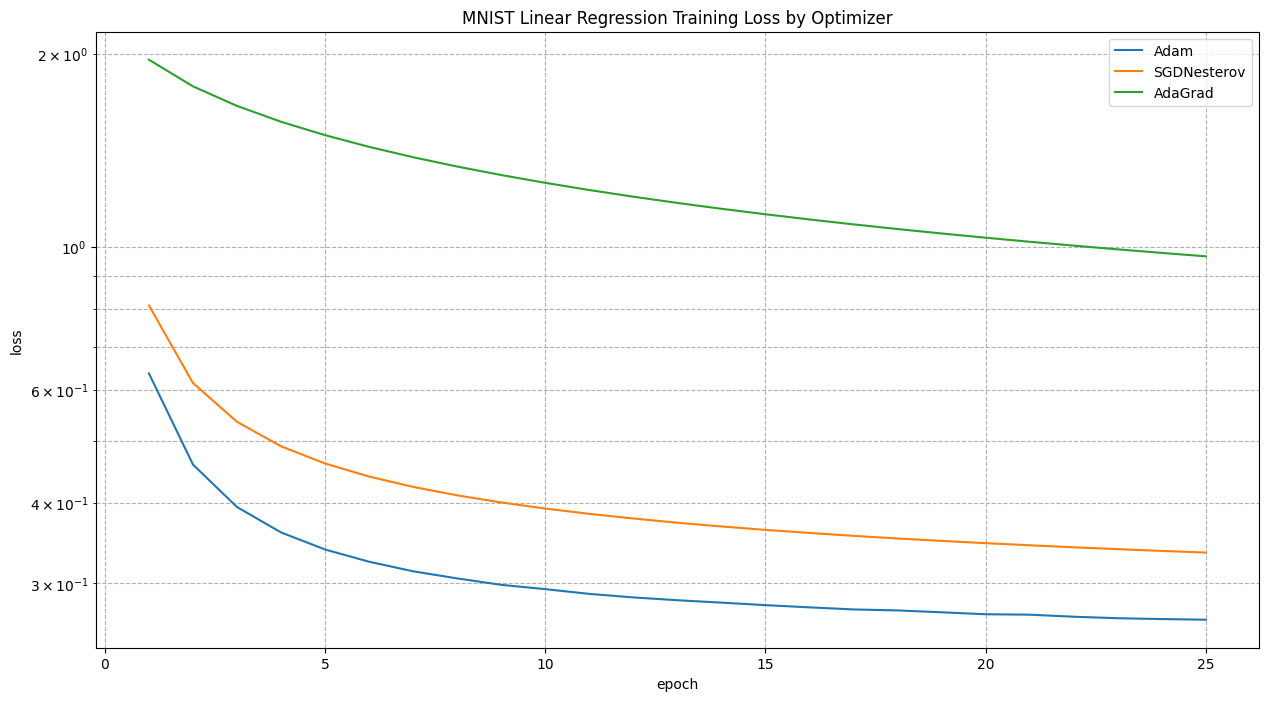

In [145]:

plt.figure(figsize=(15, 8))
for result in result_list:
    plt.plot(range(1,epochs+1), result[1], label=result[0])

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.title("MNIST Linear Regression Training Loss by Optimizer")
plt.grid(True, which="both", ls="--")
plt.legend()
# Render the plot
plt.show()

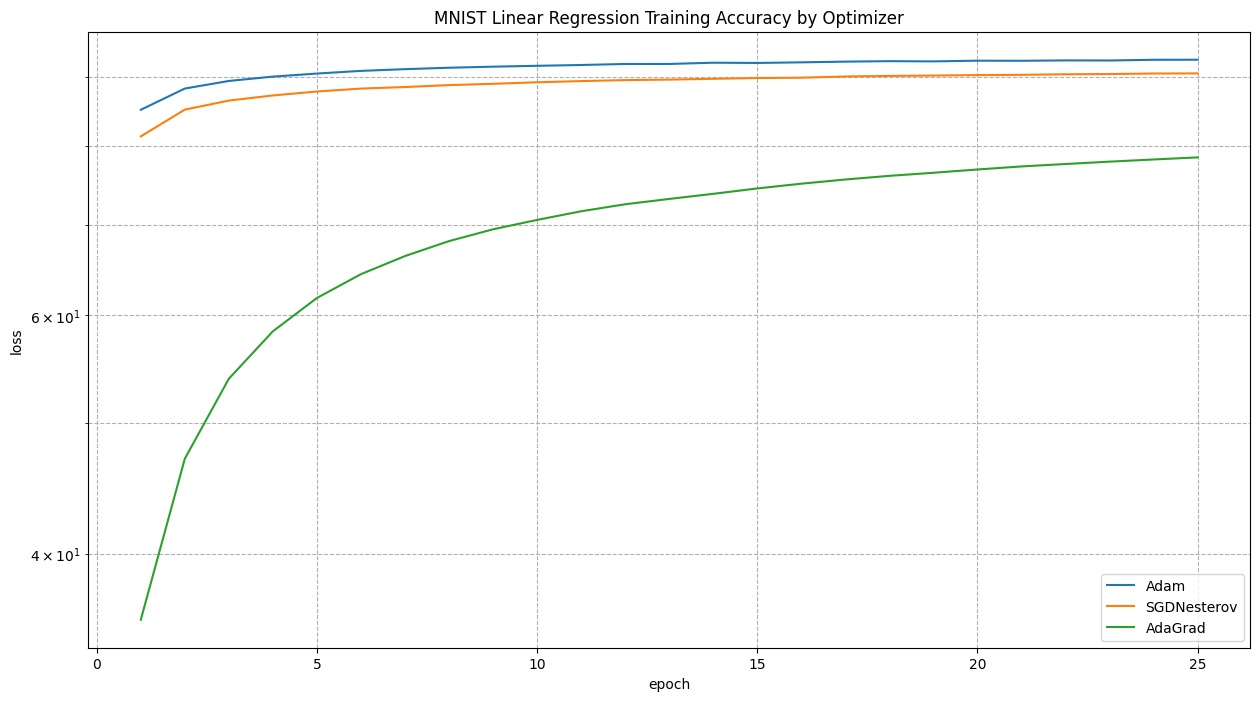

In [146]:

plt.figure(figsize=(15, 8))
for result in result_list:
    plt.plot(range(1,epochs+1), result[2], label=result[0])

plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.title("MNIST Linear Regression Training Accuracy by Optimizer")
plt.grid(True, which="both", ls="--")
plt.legend()
# Render the plot
plt.show()

# IMDB BoW